# Data Env

In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

'''Sklearn'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')

'''gensim'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML

In [3]:
#read cleaned data
from ast import literal_eval
data = pd.read_csv("../Data/StackOverflow_questions_2009_2020_cleaned.csv",
                   sep=";", index_col=0, 
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})
data.head(5)

,Title,Body,Score,Tags
Id,,,,
4,[decimal],"[variable, trans, variable, opacity, app, erro...",792,[c#]
13,"[user, timezone]","[way, web, server, user, timezone, web, page, ...",698,[html]
19,"[way, value]","[way, value, challenge, way, constant, number,...",350,"[performance, algorithm]"
123,"[java, lib, app, csv, xml, file]","[application, library, java, data, file, file,...",120,[java]
888,"[php, script]","[php, script, debugging, error, reporting, bre...",403,"[php, eclipse]"


In [4]:
data.shape

(76060, 4)

# Preproc 

In [5]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(5)

Id
4      [decimal, variable, trans, variable, opacity, ...
13     [user, timezone, way, web, server, user, timez...
19     [way, value, way, value, challenge, way, const...
123    [java, lib, app, csv, xml, file, application, ...
888    [php, script, php, script, debugging, error, r...
Name: Full_doc, dtype: object

In [6]:
#Define X & y
X = data["Full_doc"]
y = data["Tags"]

# Initialize the "CountVectorizer" for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X: (76060, 636)
Shape of y: (76060, 50)


In [7]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242, 636)
X_test shape : (22818, 636)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


# Unsurpervised Modelling 

In [8]:
# Create dic (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]]


In [9]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('decimal', 1),
  ('error', 1),
  ('opacity', 1),
  ('trans', 1),
  ('type', 1),
  ('variable', 2)]]

In [10]:
# Build LDA model
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.010079560002617

Coherence Score:  0.4301484689533795


In [11]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.157704 -0.037886       1        1  9.389415
5      0.117957 -0.016424       2        1  8.719666
6      0.062868 -0.103630       3        1  6.866995
14    -0.120855 -0.005190       4        1  6.246663
9     -0.075332  0.037492       5        1  6.061171
19    -0.043745  0.040702       6        1  5.546251
0      0.064623 -0.018457       7        1  5.537365
16     0.001459  0.063309       8        1  5.455350
18     0.063406 -0.084103       9        1  4.973660
1      0.103342  0.173524      10        1  4.512090
10    -0.023445 -0.029332      11        1  4.473127
17     0.100460 -0.041707      12        1  4.224229
12    -0.003889 -0.011776      13        1  3.950891
2      0.023842  0.005568      14        1  3.757316
13    -0.126380  0.070579      15        1  3.730601
7      0.037066 -0.001796      16        1  3.654282
3     -0.003460  0.024176      17        1  3.430024
8     -0.052331 -0.034463      18        1  3.367455
4     -0.032147 -0.077911      19        1  3.175393
11     0.064267  0.047326      20        1  2.928057, topic_info=          Term          Freq         Total Category  logprob  loglift
48        file  35368.000000  35368.000000  Default  30.0000  30.0000
85       class  23147.000000  23147.000000  Default  29.0000  29.0000
11      string  15511.000000  15511.000000  Default  28.0000  28.0000
5         type  18185.000000  18185.000000  Default  27.0000  27.0000
307      image  10209.000000  10209.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
14         way    822.019021  29974.559978  Topic20  -4.5135  -0.0655
1183   android    544.457568   8421.020979  Topic20  -4.9254   0.7921
34      script    520.094951   7046.207119  Topic20  -4.9712   0.9246
6     variable    501.480042   7986.809822  Topic20  -5.0077   0.7628
29      number    508.205311  14610.604177  Topic20  -4.9943   0.1722

[1718 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7014      12  0.936557            aaaa
8037      20  0.936167       accessory
9866      15  0.874603  accountmanager
7980       7  0.971803    accumulation
10122      2  0.007522       actionbar
...      ...       ...             ...
4136      13  0.068159            zoom
4136      14  0.006816            zoom
4136      16  0.640693            zoom
4136      17  0.020448            zoom
4136      19  0.013632            zoom

[10727 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 7, 15, 10, 20, 1, 17, 19, 2, 11, 18, 13, 3, 14, 8, 4, 9, 5, 12])

## LDA optimization 

In [12]:
import time
# Iteration
# best number of topics?
coherence_test = []
for k in np.arange(1,90,9):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 10
Fitting LDA for K = 19
Fitting LDA for K = 28
Fitting LDA for K = 37
Fitting LDA for K = 46
Fitting LDA for K = 55
Fitting LDA for K = 64
Fitting LDA for K = 73
Fitting LDA for K = 82


In [13]:
# coherence scores into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,10.996138
1,10,0.433729,21.766520
2,19,0.422732,25.195597
3,28,0.414152,26.135381
4,37,0.417606,29.005065
5,46,0.410977,31.713820
6,55,0.406478,44.576256
7,64,0.408452,50.836583
8,73,0.406474,78.548938
9,82,0.405533,115.219811


In [14]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 10


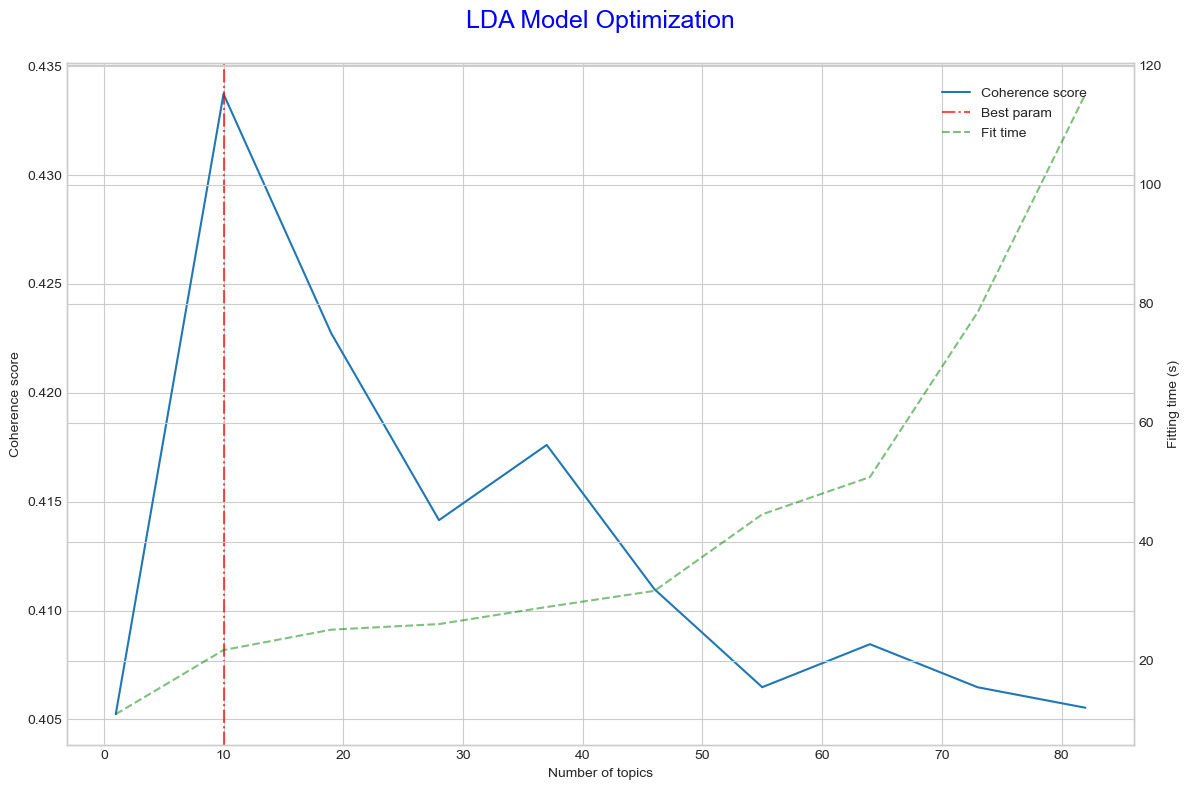

In [15]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Reducing the range of number of topics 

In [16]:
coherence_test = []
for k in np.arange(1,20,2):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 3
Fitting LDA for K = 5
Fitting LDA for K = 7
Fitting LDA for K = 9
Fitting LDA for K = 11
Fitting LDA for K = 13
Fitting LDA for K = 15
Fitting LDA for K = 17
Fitting LDA for K = 19


In [17]:
# coherence scores with the new range into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,11.367529
1,3,0.401154,20.643518
2,5,0.408836,21.524788
3,7,0.425425,20.831077
4,9,0.430737,23.625554
5,11,0.435295,23.507163
6,13,0.431968,22.734698
7,15,0.426824,24.222759
8,17,0.425162,23.736318
9,19,0.422732,24.899592


In [18]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 11


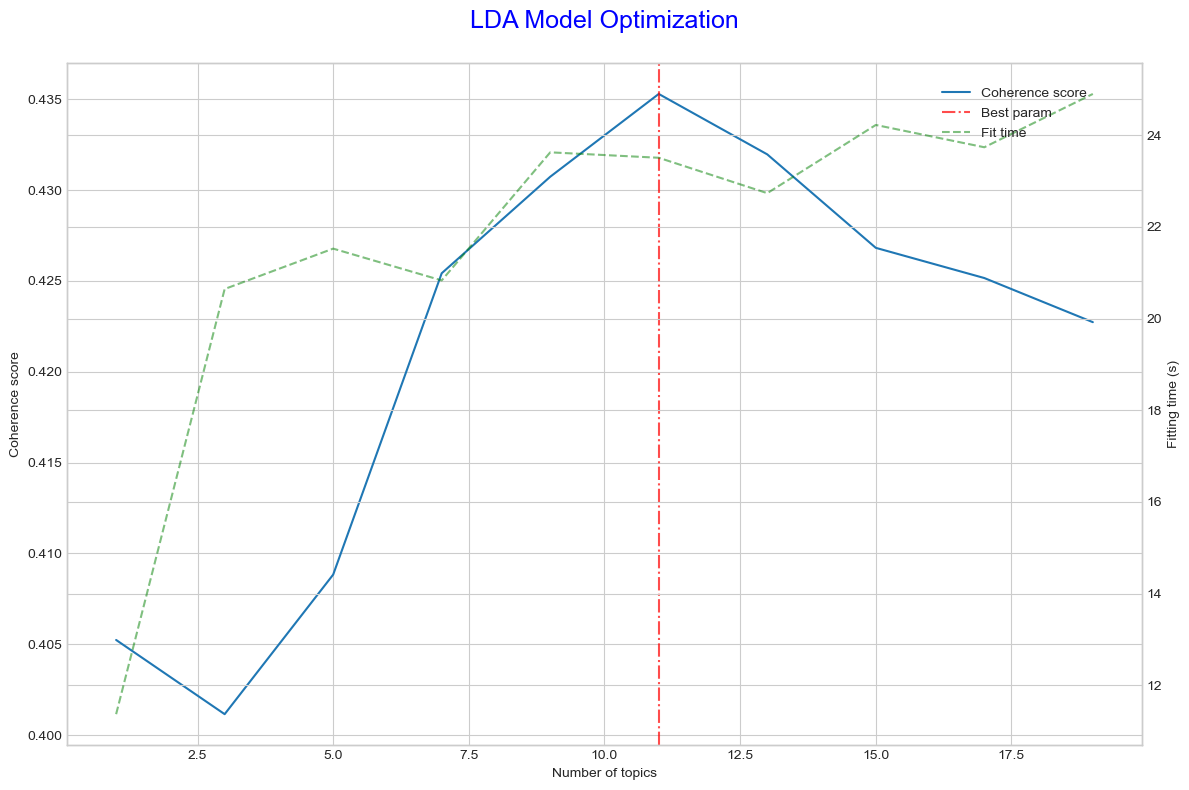

In [82]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Initialize with best topics number

In [19]:
#re-initialize with best topics number 
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_topics_k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.078256  0.091495       1        1  13.802070
8      0.116015 -0.047622       2        1  12.166713
9      0.044632 -0.078913       3        1  12.077741
6      0.003891  0.091495       4        1  10.954788
0     -0.024701  0.051807       5        1   9.266695
1     -0.152971 -0.104615       6        1   7.697294
10     0.042432 -0.009023       7        1   7.484185
4      0.069359  0.029183       8        1   7.256597
3     -0.005954 -0.034531       9        1   6.760648
7     -0.021499  0.027836      10        1   6.359616
2      0.007053 -0.017111      11        1   6.173652, topic_info=         Term          Freq         Total Category  logprob  loglift
48       file  35312.000000  35312.000000  Default  30.0000  30.0000
85      class  22850.000000  22850.000000  Default  29.0000  29.0000
11     string  14803.000000  14803.000000  Default  28.0000  28.0000
307     image  10328.000000  10328.000000  Default  27.0000  27.0000
117     table  10697.000000  10697.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
47       data   1034.207923  20808.821818  Topic11  -5.0298  -0.2169
762   request    753.910466   6770.097337  Topic11  -5.3459   0.5899
223     issue    830.277347  12334.820324  Topic11  -5.2494   0.0865
137  function    904.878666  26899.524325  Topic11  -5.1634  -0.6072
13       user    757.205294  14992.633994  Topic11  -5.3415  -0.2008

[1026 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
7751      1  0.023064  acceleration
7751      2  0.107632  acceleration
7751      4  0.023064  acceleration
7751      5  0.007688  acceleration
7751      7  0.015376  acceleration
...     ...       ...           ...
3903      7  0.564030          zone
3903      8  0.018313          zone
3903      9  0.146501          zone
3903     10  0.080576          zone
3903     11  0.036625          zone

[4590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 10, 7, 1, 2, 11, 5, 4, 8, 3])

In [20]:
from imp import reload

In [21]:
#  Document X topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)
doc_topic.head(3)

document/tag :  (76060, 50)
document/topic :  (76060, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.010144,0.010145,0.010142,0.010142,0.010143,0.755670,0.010143,0.010145,0.153041,0.010143,0.010143
1,0.006994,0.006994,0.156882,0.006994,0.006994,0.006994,0.006994,0.006994,0.359809,0.006994,0.427356
2,0.001977,0.001977,0.001977,0.001977,0.001977,0.484419,0.001977,0.001977,0.001977,0.001977,0.497784


In [22]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
#topic X tags matrix
# Matricial multiplication with DocumentXTopics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized) # rows represent topics
print(topic_tag.shape) # columns represent the disctribution of the associated tags
topic_tag

(11, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,361.905313,243.854281,140.485429,10.320872,93.160297,44.419178,9.656634,22.198352,703.567044,886.169468,...,36.497990,20.347786,11.584927,369.792536,195.371123,80.991736,29.916432,19.433163,73.205309,20.811842
1,92.754992,698.989437,535.573478,138.135886,51.606981,34.798142,50.357956,28.444929,289.151267,402.532779,...,43.698056,34.264230,6.832903,76.581464,40.522882,55.436575,124.303899,14.566585,26.352318,60.717282
2,246.847105,227.193700,171.104688,58.118431,61.627012,85.532394,41.214301,106.931419,181.516319,710.642566,...,61.765936,48.866023,39.880481,55.627178,31.557214,512.652814,25.562417,23.112930,47.717297,12.602008
3,177.726709,239.505363,356.341901,95.307169,26.487612,100.334688,61.166526,10.104395,113.268004,484.461924,...,31.053922,39.780272,15.109623,85.598319,43.034347,19.911175,38.132978,17.052948,47.481729,15.316570
4,327.470178,80.591318,120.871526,24.720956,26.183538,139.546544,126.569245,13.894645,98.813302,936.325720,...,42.175774,84.858464,163.373155,819.568178,533.965176,24.290598,19.624809,26.458428,51.369847,17.314694
5,337.235129,960.855585,124.416801,104.001621,928.001157,37.035900,32.395070,42.620550,1503.150087,1256.720599,...,110.677765,26.017096,8.323085,90.720442,50.408248,290.139114,182.637169,35.196592,30.960286,27.416343
6,556.414131,44.817294,277.280317,58.052877,66.311855,68.949971,53.782439,7.316057,377.731141,1650.358676,...,52.980363,30.891201,206.238261,24.219929,14.094067,71.530787,99.102648,111.503009,26.998878,55.874631
7,191.447517,99.731369,550.273782,27.289216,37.064827,53.425636,84.040792,15.382990,434.879654,641.078474,...,27.333843,30.361714,18.860670,18.523683,9.531301,63.463684,65.221937,22.691091,63.773731,45.221161
8,356.585862,20.944545,2150.013963,131.378039,14.739570,291.328448,164.617092,37.932413,174.729824,923.659794,...,81.696431,151.879559,74.012452,76.591285,127.564167,16.929964,127.907902,49.146382,158.813689,353.857658
9,361.921355,40.903748,936.096165,109.706473,32.763466,219.766504,163.646781,252.622990,316.737060,1080.425295,...,64.250090,82.338230,60.333918,35.108480,32.155945,37.278205,50.768240,318.568478,447.927304,84.129177


In [24]:
# dataframe of predictions
y_results = pd.DataFrame(y)
y_results["rep_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

In [25]:
y_results

,Tags,rep_topic,nb_tags
Id,,,
4,[c#],5,1
13,[html],10,1
19,"[performance, algorithm]",10,2
123,[java],9,1
888,"[php, eclipse]",2,2
...,...,...,...
36371706,"[arrays, performance]",5,2
36371748,"[java, spring]",9,2
36372274,[git],10,1


In [26]:
#groupby y binarized index
df_y_2 = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_2.groupby(df_y_2.index)))

#intiate a list of tags numbers 
num_tags = []
for key, value in df_dict.items():
    check = value.columns[(value == 1).any()]
    num_tags.append(check.to_list())
print(num_tags)

[[9], [20], [1, 35], [23], [15, 36], [29], [36], [0, 34, 35], [43, 44], [0, 9], [28, 44], [44], [37], [8, 10], [0, 9], [43], [0], [36], [31], [8], [40, 45], [17, 48], [8, 28], [6], [30], [12, 20], [1, 10, 34], [24], [48], [0, 9], [31, 35], [43], [47], [23], [21, 22, 48], [23], [24], [37], [31], [23], [10], [10, 35], [0, 9, 35], [37], [0, 9], [12], [23], [10], [1], [23], [23, 45], [8, 10], [9], [8, 10], [1], [9], [8], [8], [23], [19], [12], [5, 47], [8, 10], [31], [20, 24, 39], [0, 9], [37], [1, 9], [48], [8, 10], [48], [23], [45], [0, 9], [23], [44], [24], [10], [0], [0, 9], [37], [7], [37], [10], [48], [24], [24], [44], [8, 10], [36], [20], [20, 24], [9], [37], [7], [9], [36, 39], [9, 48], [20, 24], [1], [1], [37], [20], [0, 9], [15], [1, 35], [1], [10], [7, 27], [47], [24], [10, 16], [9], [23], [8], [8, 10], [0, 9], [20], [9], [47], [18, 24], [28], [5, 6], [7, 27], [0, 9], [12, 20], [1], [1, 9], [47], [17], [24], [24], [26, 40, 41], [37], [17], [12, 20], [36], [9], [7], [23], [10, 24

In [27]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
y_results["y_true"] = num_tags
y_results.head(3)

,Tags,rep_topic,nb_tags,y_true
Id,,,,
4,[c#],5,1,[9]
13,[html],10,1,[20]
19,"[performance, algorithm]",10,2,"[1, 35]"


In [29]:
# Selecting predicted tags from Topics X Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.rep_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

/var/folders/_5/rhjg3s115y30bg6bd3kvpsj00000gn/T/ipykernel_21396/1552659229.py:6: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,Tags,rep_topic,nb_tags,y_true,y_pred
Id,,,,,
4,[c#],5,1,[9],[10]
13,[html],10,1,[20],[23]
19,"[performance, algorithm]",10,2,"[1, 35]","[23, 24]"


## LDA Model evaluation

In [30]:
metrics

<module 'sklearn.metrics' from '/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/__init__.py'>

In [31]:
def metrics_scores(model, df, y_true, y_pred):
    if(df is not None):
        scores_df = df
    else:
        scores_df = pd.DataFrame(index=["Accuracy", "F1",
                                         "Recall",
                                         "Precision"],
                                          columns=[model])
    #intiate scores' list
    scores = []
    #append scores
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    scores_df[model] = scores
    
    return scores_df

In [32]:
# Create matrix for predicted and true tags y
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [33]:
#create df of lds metrics chosen above
df_metrics = metrics_scores("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,LDA
Accuracy,0.136221
F1,0.287827
Recall,0.225498
Precision,0.161093


**LDA non supervised approach is not adapted seen the scores results.**

# Supervised Approach 

## Logistic Regression

### Logit Grid search

In [34]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

#Grid search best params
multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [35]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [36]:
logit_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,199.878453,5.900411,0.208374,0.039165,100,False,l1,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.576196,...,0.574785,0.002242,4,0.642562,0.642573,0.643618,0.647798,0.644799,0.644270,0.001947
1,62.144480,1.862427,0.282254,0.049664,100,False,l2,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.580745,...,0.580646,0.001777,2,0.634849,0.634559,0.635708,0.639159,0.636971,0.636249,0.001679
2,89.355266,5.997989,0.242615,0.069692,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582465,...,0.581795,0.001488,1,0.629987,0.629752,0.630639,0.633500,0.632224,0.631220,0.001430
3,30.676787,0.576672,0.210792,0.031619,10,False,l2,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.578405,...,0.577189,0.001247,3,0.615259,0.614406,0.615599,0.618281,0.616364,0.615982,0.001310
4,32.866165,0.796663,0.207836,0.036535,1.0,False,l1,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.569728,...,0.567435,0.001611,5,0.584677,0.583742,0.584100,0.587537,0.584576,0.584926,0.001348
5,18.393896,0.709593,0.220130,0.045329,1.0,False,l2,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.540823,...,0.539112,0.002224,6,0.557612,0.556724,0.557880,0.559746,0.558826,0.558158,0.001039
6,13.468129,0.294757,0.261679,0.064956,0.1,False,l1,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.487132,...,0.484496,0.003438,7,0.486598,0.485530,0.488027,0.489030,0.489560,0.487749,0.001500
7,12.566105,0.598593,0.117465,0.010994,0.1,False,l2,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.356205,...,0.351351,0.003655,8,0.354953,0.356731,0.358757,0.358854,0.358088,0.357477,0.001472


In [37]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,89.355266,5.997989,0.242615,0.069692,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582465,...,0.581795,0.001488,1,0.629987,0.629752,0.630639,0.6335,0.632224,0.63122,0.00143


###  Logit Predictions

In [38]:
# Predict
y_test_predicted_labels = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('html', 'javascript'), ('google-chrome', 'javascript'), ('android',), ('android',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [39]:
#Evaluation
df_metrics_logit = metrics_scores("Logit", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels)
df_metrics_logit

,LDA,Logit
Accuracy,0.136221,0.341835
F1,0.287827,0.616698
Recall,0.225498,0.487326
Precision,0.161093,0.744606


## Random Forest

### Grid Search

In [40]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on sampled data to reduce fitting time
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [41]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


In [42]:
#formatting for the arguments of the Model 
rfc_best_params_arg = {}
for k, v in rfc_best_params.items():
    rfc_best_params_arg[k.replace("estimator__","")] = v

In [43]:
# Refit RandomForestClassifier with best_params on full data
rfc_best_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_arg))
rfc_best_model.fit(X_train, y_train)

[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.668, test=0.539) total time=  20.6s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.662, test=0.506) total time=  20.0s
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.814, test=0.554) total time=  35.6s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.818, test=0.538) total time=  39.9s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=0.997, test=0.344) total time=  50.2s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.714, test=0.518) total time=  21.0s
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=5, es

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=25,
                                                     min_samples_leaf=5))

### Predict

In [44]:
# Predict
y_test_predicted_labels_rfc = rfc_best_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('eclipse', 'java'), ('html', 'javascript'), ('css', 'html', 'javascript', 'jquery'), ('android',), ('android', 'ios', 'iphone', 'objective-c')]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [45]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc)
df_metrics_rfc

,LDA,Logit,RandomForest
Accuracy,0.136221,0.341835,0.222412
F1,0.287827,0.616698,0.570461
Recall,0.225498,0.487326,0.734260
Precision,0.161093,0.744606,0.524502


## Unpredicted tags

Giving that Logistic regression and Random Forest models perform quite on a similar steak of evaluation, they seem coherent with the data. to be able to tell them apart, we shall see **the number of rows where tags weren't predicted**: 

In [46]:
#tags per row for y_pred logit
Tags_row_logit = y_test_predicted_labels.sum(axis=1)
null_rate_logit = round(((Tags_row_logit.size - np.count_nonzero(Tags_row_logit))
                      /Tags_row_logit.size)*100,2)

#tags per row for y_pred rfc
Tags_row_rfc = y_test_predicted_labels_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_row_rfc.size - np.count_nonzero(Tags_row_rfc))
                       /Tags_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_logit))
print("Random Forest: {}%".format(null_rate_rfc))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 28.44%
Random Forest: 4.54%


Random Forest model seems more adequate to this multi classification task.

# Neural networks

In [47]:
# NN dependencies 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from tensorflow.keras import Sequential, layers
from gensim.models import Word2Vec

In [49]:
# new holdout
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242,)
X_test shape : (22818,)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


In [50]:
X_train

Id
24407931    [java, lambda, expression, iteration, folk, ex...
15140370    [localdb, instance, name, sql, script, sql, se...
20148       [myisam, innodb, project, lot, database, inser...
19145332    [nltk, counting, frequency, bigram, python, nl...
34307379    [table, element, function, table, code, line, ...
                                  ...                        
4937263     [object, networking, number, system, idea, net...
28761365    [promise, story, promise, way, promise, error,...
8167754     [postgres, architecture, app, instance, nginx,...
11165200    [list, view, method, child, publication, item,...
32805916    [compute, jaccard, matrix, matrix, sparsecsr_m...
Name: Full_doc, Length: 53242, dtype: object

## WOR2VEC Embedding

In [51]:
word2vec = gensim.models.Word2Vec(sentences=X_train,
                                  vector_size=300,
                                  min_count=1,
                                  window=10)

In [52]:
#embedding functions 
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

def embedding(word2vec, sentences):
    '''function that, given a list of sentence (each sentence being a list of words/strings),
    returns a list of embedded sentences (each sentence is a matrix).'''
    
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
   

In [53]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=50)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=50)

In [54]:
#assertions
assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

In [55]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [56]:
def init_model():
    model = Sequential()
    #model.add(layers.Masking())
    model.add(layers.LSTM(300, activation='tanh'))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_m, recall_m, precision_m])
    
    return model

model = init_model()

In [57]:
X_train_pad

array([[[ 3.6547467e-01,  1.0796775e+00,  8.0683392e-01, ...,
         -1.9631052e+00,  9.5259023e-01, -2.9780218e-01],
        [ 2.8005111e-01,  5.5757785e-01, -5.3258961e-01, ...,
         -1.8378842e-01, -7.6073587e-01,  6.3196433e-01],
        [ 1.5201135e+00,  7.6662380e-01, -1.2531413e-01, ...,
         -1.2492312e+00, -2.0963434e-02,  4.3526453e-01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-1.4010572e-01,  6.9407418e-02,  1.6147409e-02, ...,
          2.2677815e-02,  4.3535106e-02, -1.1952861e-01],
        [-1.1848173e+00, -1.3778642e+00,  1.8726313e-01, ...,
         -6.3927010e-02,  6.1524707e-01, -1.7061620e+00],
        [-5.3806633e-01, 

In [58]:
X_train_pad.shape

(53242, 50, 300)

In [59]:
y_train.shape

(53242, 50)

In [63]:
model.build(y_train.shape[0])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                7550      
                                                                 
Total params: 864,200
Trainable params: 864,200
Non-trai

In [62]:
# 
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
                      epochs=10,
                      batch_size=32,
                      verbose=1,
                      validation_data=(X_test_pad, y_test),
                      callbacks= [es]
                     )

Epoch 1/10
1664/1664 [==============================] - 170s 102ms/step - loss: 0.0854 - accuracy: 0.3961 - f1_m: 0.3387 - recall_m: 0.2516 - precision_m: 0.5721 - val_loss: 0.0616 - val_accuracy: 0.5424 - val_f1_m: 0.5718 - val_recall_m: 0.4676 - val_precision_m: 0.7441
Epoch 2/10
1664/1664 [==============================] - 156s 94ms/step - loss: 0.0593 - accuracy: 0.5630 - f1_m: 0.5824 - recall_m: 0.4738 - precision_m: 0.7661 - val_loss: 0.0554 - val_accuracy: 0.5767 - val_f1_m: 0.6207 - val_recall_m: 0.5244 - val_precision_m: 0.7678
Epoch 3/10
1664/1664 [==============================] - 194s 117ms/step - loss: 0.0539 - accuracy: 0.5884 - f1_m: 0.6226 - recall_m: 0.5223 - precision_m: 0.7789 - val_loss: 0.0540 - val_accuracy: 0.5784 - val_f1_m: 0.6357 - val_recall_m: 0.5476 - val_precision_m: 0.7641
Epoch 4/10
1664/1664 [==============================] - 235s 141ms/step - loss: 0.0506 - accuracy: 0.6056 - f1_m: 0.6476 - recall_m: 0.5533 - precision_m: 0.7878 - val_loss: 0.0528 - va

In [66]:
#evaluate on test set 
scores = model.evaluate(X_test_pad, y_test)
scores

714/714 [==============================] - 31s 43ms/step - loss: 0.0521 - accuracy: 0.5892 - f1_m: 0.6435 - recall_m: 0.5509 - precision_m: 0.7799


[0.05208996310830116,
 0.5891839861869812,
 0.643469512462616,
 0.5509036779403687,
 0.7799243927001953]

In [67]:
df_metrics_rfc

,LDA,Logit,RandomForest
Accuracy,0.136221,0.341835,0.222412
F1,0.287827,0.616698,0.570461
Recall,0.225498,0.487326,0.734260
Precision,0.161093,0.744606,0.524502


In [68]:
df_metrics_rfc["Keras_NN_w2v"] = [scores[i] for i in [1,2,3,4]]
df_metrics_rfc

,LDA,Logit,RandomForest,Keras_NN_w2v
Accuracy,0.136221,0.341835,0.222412,0.589184
F1,0.287827,0.616698,0.570461,0.643470
Recall,0.225498,0.487326,0.734260,0.550904
Precision,0.161093,0.744606,0.524502,0.779924


In [71]:
df_metrics_rfc.to_excel("df_metrics_scores.xlsx")

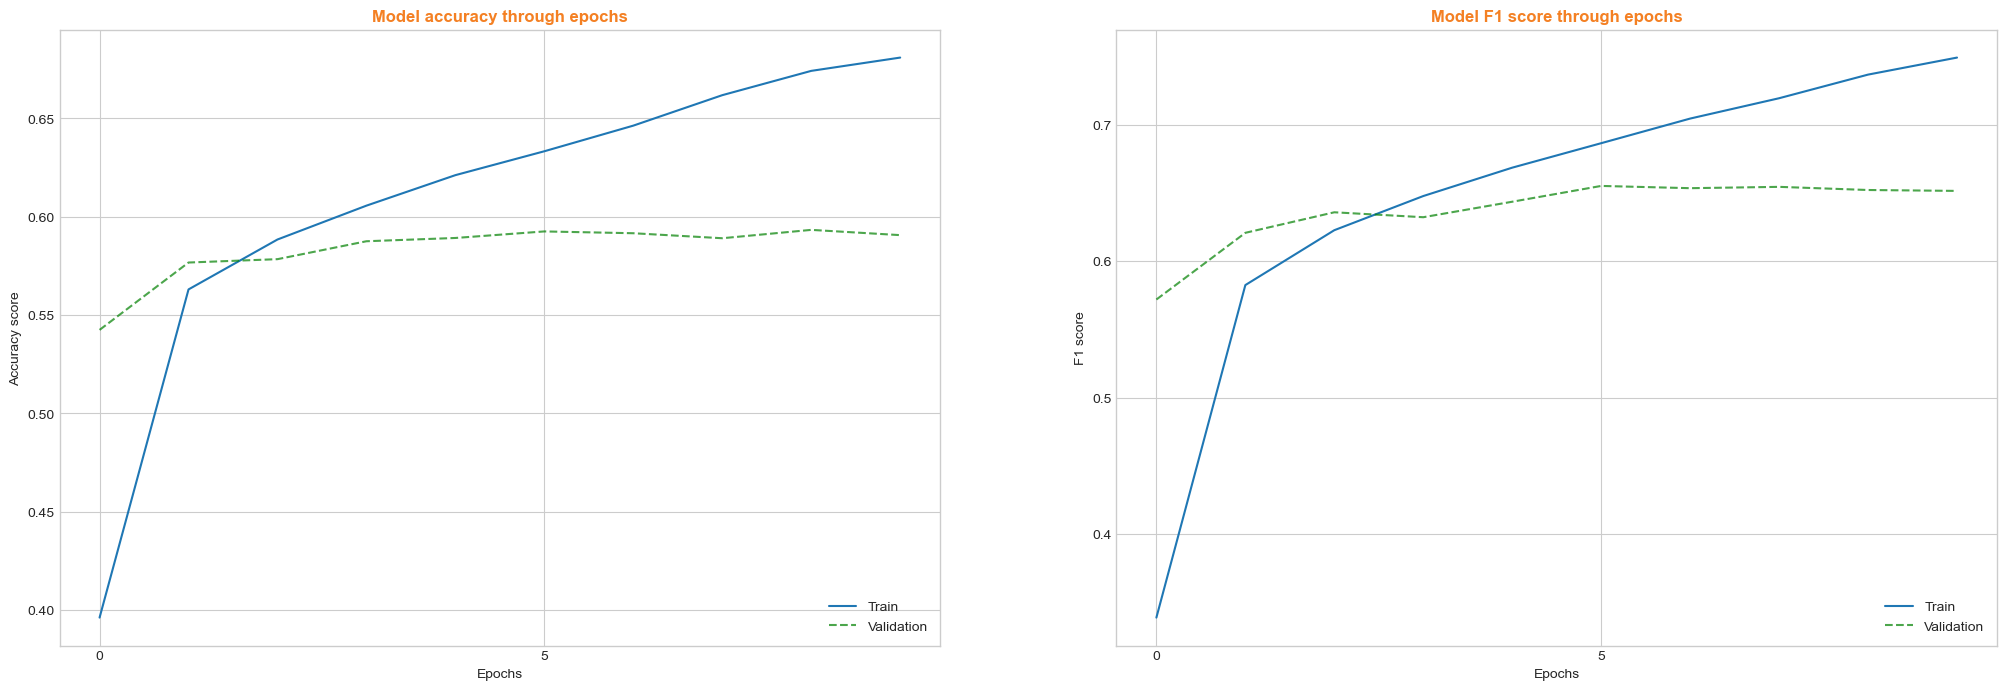

In [79]:
#visualize model accuracy and F1 score
train_accuracy = history.history.get('accuracy', [])
train_f1 = history.history.get('f1_m', [])
val_accuracy = history.history.get('val_accuracy', [])
val_f1 = history.history.get('val_f1_m', [])

fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(np.arange(0,10,1),
             train_accuracy,
             label="Train")
axes[0].plot(np.arange(0,10,1),
             val_accuracy,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[0].set_xticks(np.arange(0,10,5))
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy score")
axes[0].set_title('Model accuracy through epochs',
                  color='#f48023', fontweight='bold')
axes[0].legend(loc=4)

axes[1].plot(np.arange(0,10,1),
             train_f1, label="Train")
axes[1].plot(np.arange(0,10,1),
             val_f1,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[1].set_xticks(np.arange(0,10,5))
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1 score")
axes[1].set_title('Model F1 score through epochs',
                  color='#f48023', fontweight='bold')
axes[1].legend(loc=4)

plt.show()

In [80]:
# predicitions

# Make prediction with Keras Model using W2V embedding 
y_test_predicted_labels_w2v = model.predict(X_test_pad)
y_test_predicted_labels_w2v  = np.where(y_test_predicted_labels_w2v  >= 0.5, 1, 0)

714/714 [==============================] - 28s 39ms/step


In [83]:
# Inverse transform
y_test_pred_inversed_w2v = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_w2v)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_w2v[0:5])
print("True:", y_test_inversed[0:5])

Tags_per_row_keras = y_test_predicted_labels_w2v.sum(axis=1)
null_rate_keras = round(((Tags_per_row_keras.size - np.count_nonzero(Tags_per_row_keras))
                       /Tags_per_row_keras.size)*100,2)
print("\n")
print("-"*50)
print("Percentage of non tagged question for Keras model using w2v embedding")
print("-" * 50)
print("Keras model: {}%".format(null_rate_keras))

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('eclipse', 'java'), ('html', 'javascript'), ('css',), ('android',), ('android',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


--------------------------------------------------
Percentage of non tagged question for Keras model using w2v embedding
--------------------------------------------------
Keras model: 13.8%


## BERT Embedding

In [84]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.0
2.9.0
Num GPUs Available:  1
False


In [85]:
# Bert
from transformers import *
import time

<frozen importlib._bootstrap>:283: DeprecationWarning:

the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/generation_tf_utils.py:24: FutureWarning:

Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/models/deit/image_processing_deit.py:86: DeprecationWarning:

BICUBIC is deprecated and will be removed in Pillow 10 (2023

In [86]:
# untokenize data to take into account Bert implied Tokenization
def untokenize(data):
    for tokens in data:
        yield ' '.join(tokens)
        
X_untokenized = list(untokenize(X))
X_untokenized

['decimal variable trans variable opacity app error type',
 'user timezone way web server user timezone web page header part string',
 'way value way value challenge way constant number program test way inline assembly version theory option baseline version test in version gcc auto constant version testing program inline assembly stuff system build script configuration testing compiler flag bit bit optimization order test version top time',
 'java lib app csv xml file application library java data file file tag row column heading',
 'php script php script debugging error reporting breakpoint phpeclipse term way phpstorm ide',
 'diversion point imprecision part mathematician point implementation dispute language implementation method result',
 'xampp apache file htdocs folder xampp file directory instance file xampp file default configuration way apache file apache access content project directory project directory edit apache question title',
 'class performance benefit lot optimizatio

In [87]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model_bert = TFAutoModel.from_pretrained(model_type)

loading configuration file config.json from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db42

In [88]:
# sentences processing function 
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot


In [89]:
# features creation function
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [96]:
len(X_untokenized[:3000])

3000

In [98]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model_bert, model_type, X_untokenized[:10000], 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891c

1/1 [==============================] - 1s 747ms/step


1/1 [==============================] - 1s 806ms/step


1/1 [==============================] - 1s 831ms/step


1/1 [==============================] - 1s 721ms/step


1/1 [==============================] - 1s 576ms/step


1/1 [==============================] - 1s 811ms/step


1/1 [==============================] - 1s 666ms/step
temps traitement :  1097.0


In [99]:
#holdout
#NN 

array([[-0.1504677 , -0.18781541,  0.1090909 , ..., -0.15699613,
        -0.28794414,  0.38851807],
       [ 0.0108176 , -0.2131879 ,  0.4182721 , ..., -0.30971128,
        -0.0398398 ,  0.34313178],
       [ 0.18069465, -0.11888204,  0.28004625, ..., -0.44956726,
        -0.23204418, -0.0152758 ],
       ...,
       [-0.10653795, -0.22928075,  0.3347232 , ..., -0.21671864,
        -0.30861074,  0.05208834],
       [ 0.08604047,  0.10514589,  0.0344813 , ..., -0.36397436,
         0.12923919,  0.35650393],
       [ 0.19070767,  0.5087419 ,  0.3495859 , ..., -0.49449176,
        -0.2595355 ,  0.22471559]], dtype=float32)

## USE 

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = X_train_untokenized

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
#Example
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFBertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
inputs = tokenizer(X_train_untokenized, padding=True, truncation=True, max_length=50, return_tensors="tf")
outputs = model(inputs)
